オリジナルの作成： 2011/04/22

<html id="* 第3章-Sageを使って逐次ベイズ学習を試してみる">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>第3章-Sageを使って逐次ベイズ学習を試してみる</h1>
	<p>
	<a href="http://www.amazon.co.jp/dp/443110013X/">パターン認識と機械学習</a>
	の３章で最も印象深い例題が、ベイズ線形回帰のパラメータ分布を逐次的に計算し、収束する様子を
	示した図3.7です。
	</p>	
	<p style="text-align: center;"><img src="images/02/fig3.7.png" alt="" /></p>
	<p>
		ここでは、Sageを使って図3.7の逐次ベイズ学習を再現してみます。
	</p>
</html>

<html id="** パラメータの分布">
	<h2>パラメータの分布</h2>
	<p>
		図3.7の例では、モデルパラメータwの事前確率分布を以下のように定義しています。原書式(3.52)
$$
		p(w|\alpha) = \mathcal{N}(w|0, \alpha^{-1} I) 
$$
		対応するwの事後分布は、線形回帰のペイズフィッティングと同じ形になります。原書式(3.53)、式(3.54)
$$
		m_N = \beta S_N \Phi^T t
$$
$$
		S^{-1}_{N} = \alpha I + \beta \Phi^T \Phi
$$
		ポイントは、事後分布の対数です。
$$
		ln p(w|t) = - \frac{\beta}{2} \sum^N_{n=1} \{ t_n - w^T\phi(x_n) \}^2 - \frac{\alpha}{2} w^T w + 定数
$$
		この第1項の指数$e^{- \frac{\beta}{2} \{ t_i - w^T\phi(x_i) \}^2}$をその直前の事前分布に掛け合わせることで$t_i$の事後分布が求まるところです。
	</p>
</html>

<html id="** 仮定">
	<h2>仮定</h2>
	<p>
		モデルパラメータwの事前確率分布の変化を見るために、$\alpha = 2.0$、精度パラメータ$\beta = (1/0.2)^2 = 25$を固定値としています。
	</p>
</html>

In [1]:
# Cholesky分解のためにscipyを使用
from scipy.linalg import *
# 初期設定：平均0，α=2.0固定のガウス分布、β=(1/0.2)^2=25
alpha = 2.0
beta = 25
mu = vector([0, 0])
sigma = matrix(2,2,alpha)
# グラフ表示用の変数
x, y = var('x, y')

<html id="** データ">
	<h2>データ</h2>
	<p>
		データとして、図3.7から最初の2点を読み取り(0.9, 0.05), (-0.6, -0.8)とし、残りを、
$$
		f(x, a) = a_0 + a_1 x 
$$
	</p>
	<p>
		ここで、$a_0 = -0.3, a_1 = 0.5$とし、一様部分$U(x|-1,1)$から選んだ$x_n$に、目的値$t_n$を以下のように計算し、
		追加しました。
$$
		t_n = f(x_n, a) + \mathcal{N}(0, 0.2) 
$$
	</p>
	
</html>

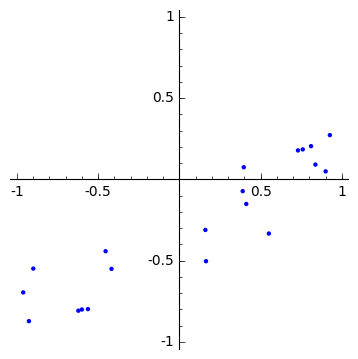

In [2]:
# データセット f(x,a) = a0 + a1*x <= a0 = -0.3, a1=0.5 
# 観測値は、tn = f(x,a) + N(0, 0.2)
# xnを一様分布U(x|-1,1)から選択する
# チェックのために、図3.7の最初の2点を(0.9, 0.05), (-0.6, -0.8)を使用する
a0 = -0.3
a1 = 0.5
a_plt = point([a0, a1], rgbcolor='red')
xv = [0.9, -0.6]
tv = [0.05, -0.8]
for xn in range(18):
    xn = 2*random() - 1
    xv += [xn]
    tv += [a0 + a1*xn + gauss(0, 0.2)]
data = zip(xv, tv)
data_plt = list_plot(zip(xv, tv))
data_plt.show(aspect_ratio=1, figsize=5, xmin=-1, xmax=1, ymin=-1, ymax=1)

<html id="** ｗの事前分布（初期分布）">
	<h2>ｗの事前分布（初期分布）</h2>
	<p>
		ｗの事前分布は、ベクトルのガウス分布の式、原著付録式(B.37)から
$$
		\mathcal{N}(x|\mu, \Sigma) = \frac{1}{(2\pi)^{D/2}} \frac{1}{|\Sigma|^{1/2}} exp \left\{ 
			\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)
			\right\}
$$
		となります。
	</p>
</html>

<html id="** データ空間">
	<h2>データ空間</h2>
	<p>
		データ空間の図は、ｗの値をランダムに選んだ関数$y(x, w)$と説明されていますが、
		私は、第11章のBox-Muller法からコレスキー分解(Cholesky decomposition)を使って
		分散$\Sigma = L L^T$となる$L$を求めて
$$
		y = \mu + L z
$$
		から空間のガウスのサンプリングを生成することにしました。
	</p>
</html>

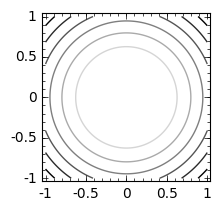

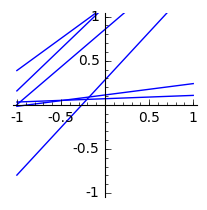

In [3]:
# ベクトルのガウス分布を定義
def gauss_v(v, mu, sigma):
    d = len(v)
    sigma_inv = sigma.inverse()
    sigma_abs_sqrt = sigma.det().sqrt()
    # sage 4.6.2ではtranspose()の代わりにcolumn()を使用する
    val = -(v - mu) * sigma_inv * (v - mu).column()/2
    return n((2*pi)^(-d/2)) * sigma_abs_sqrt^-0.5 * e^val[0]
# wの初期分布
cnt_plt = contour_plot(lambda x, y : gauss_v(vector([x,y]), mu, sigma), [x, -1, 1], [y, -1, 1], fill=False)
cnt_plt.show(aspect_ratio=1, figsize=(3))
# 6個のラインを引く
L = matrix(cholesky(sigma.numpy()))
l_plt = plot([])
for i in range(6):
    y = mu + L*vector([random(), random()])
    l_plt += plot(lambda x : y[0] + y[1]*x, [x, -1, 1])
l_plt.show(aspect_ratio=1, figsize=3, xmin=-1, xmax=1, ymin=-1, ymax=1)

<html id="*** 基底関数">
	<h3>基底関数</h3>
	<p>
		一番簡単な例として直線を使用するので、基底関数は
$$
		\phi_j(x) = x^j
$$
		としました。
	</p>
</html>

In [4]:
# Φ関数定義
def _phi(x, j):
    return x^j

<html id="*** 尤度関数">
	<h3>尤度関数</h3>
	<p>
		同様に$x_n$の観測値$t_n$対する尤度関数は、
$$
		p(t|w) = e^{- \frac{1}{2}(t_n - w^T \phi(x_n))}
$$
		となります。
	</p>
</html>

In [5]:
# 尤度関数の定義
def _likelihood(w0, w1, v):
    xn, tn = v
    return n(e^(-beta/2*(tn - w0 - w1*xn)^2))

<html id="** 1点目のプロット">
	<h2>1点目のプロット</h2>
	<p>
		最初の1点目の尤度関数をwの真の値a=(-0.3, 0.5)（赤い点）と一緒にプロットしたのが、最初の図です。
	</p>
	<p>
		次に原書式(3.53)から求めた事後確率と真の値a=(-0.3, 0.5)（赤い点）と一緒にプロットしました。
		図3.7と同じように事前分布と尤度分布を掛け合わせた形になっています。
	</p>
	<p>
		3番目は、事後分布からランダムに生成したwを元に引いた直線です。
		第1点に直線が集まっていることがわかります。
	</p>
</html>

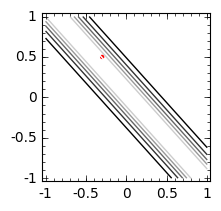

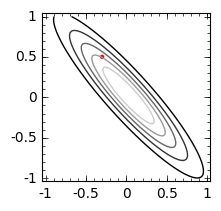

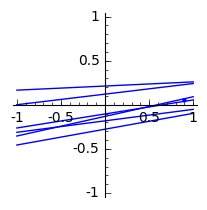

In [6]:
# グラフ表示用の変数
x, y = var('x, y')
# 最初の1点の尤度関数をプロット
v = data[0]
lf_plt = contour_plot(lambda x, y : _likelihood(x, y, v), [x, -1, 1], [y, -1, 1], fill=False)
(lf_plt + a_plt).show(aspect_ratio=1, figsize=(3))
# 1個目の事後平均と分散を計算
v = vector(xv[0:1])
t = vector(tv[0:1])
Phi = matrix([[ _phi(x,j) for j in range(2)] for x in v.list()])
Phi_t = Phi.transpose()
S_N_inv = (alpha*matrix((2),(2),1) + beta*Phi_t * Phi)
S_N = S_N_inv.inverse()
m_N = beta*S_N*Phi_t*t
# 1個目の事後分布
cnt_plt = contour_plot(lambda x, y : gauss_v(vector([x,y]), m_N, S_N), [x, -1, 1], [y, -1, 1], fill=False)
(cnt_plt + a_plt).show(aspect_ratio=1, figsize=(3))
# 6個のラインを引く
L = matrix(cholesky(S_N.numpy()))
l_plt = list_plot(zip(xv[0:1], tv[0:1]))
for i in range(6):
    y = m_N + L*vector([random(), random()])
    l_plt += plot(lambda x : y[0] + y[1]*x, [x, -1, 1])
l_plt.show(aspect_ratio=1, figsize=3, xmin=-1, xmax=1, ymin=-1, ymax=1)

<html id="** 2点目のプロット">
	<h2>2点目のプロット</h2>
	<p>
		2点目の尤度関数をwの真の値a=(-0.3, 0.5)（赤い点）と一緒にプロットしたのが、1番目の図です。
	</p>
	<p>
		2点から式(3.53)を使って求めた事後確率と真の値a=(-0.3, 0.5)（赤い点）と一緒にプロットしました。
		図3.7と同じように事後確率分布がかなり真の値に近くなっています。
	</p>
	<p>
		3番目は、事後分布からランダムに生成したwを元に引いた直線です。
		2点が求まっているので、直線は2点に近づいています。
	</p>
</html>

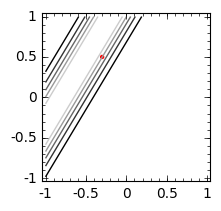

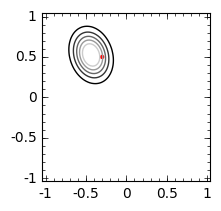

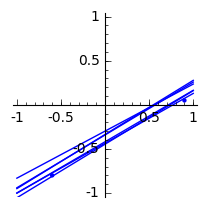

In [7]:
# グラフ表示用の変数
x, y = var('x, y')
# 第2点の尤度関数をプロット
v = data[1]
lf_plt = contour_plot(lambda x, y : _likelihood(x, y, v), [x, -1, 1], [y, -1, 1], fill=False)
(lf_plt + a_plt).show(aspect_ratio=1, figsize=3)
# 2点目の事後平均と分散を計算
v = vector(xv[0:2])
t = vector(tv[0:2])
Phi = matrix([[ _phi(x,j) for j in range(2)] for x in v.list()])
Phi_t = Phi.transpose()
S_N_inv = (alpha*matrix((2),(2),1) + beta*Phi_t * Phi)
S_N = S_N_inv.inverse()
m_N = beta*S_N*Phi_t*t
# 2点目の事後分布
cnt_plt = contour_plot(lambda x, y : gauss_v(vector([x,y]), m_N, S_N), [x, -1, 1], [y, -1, 1], fill=False)
(cnt_plt + a_plt).show(aspect_ratio=1, figsize=3)
# 6個のラインを引く
L = matrix(cholesky(S_N.numpy()))
l_plt = list_plot(zip(xv[0:2], tv[0:2]))
for i in range(6):
    y = m_N + L*vector([random(), random()])
    l_plt += plot(lambda x : y[0] + y[1]*x, [x, -1, 1])
l_plt.show(aspect_ratio=1, figsize=3, xmin=-1, xmax=1, ymin=-1, ymax=1)

<html id="** 20点目のプロット">
	<h2>20点目のプロット</h2>
	<p>
		20点になると事後確率と真の値a=(-0.3, 0.5)（赤い点）にかなり接近した形になります。
	</p>
	<p>
		ベイズ的なフィッティングがどうやって学習するのかこの例を通じて実感することができました。
		とても貴重な例題だと思います。
	</p>
</html>

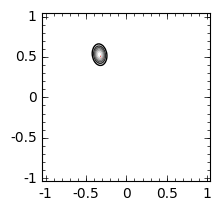

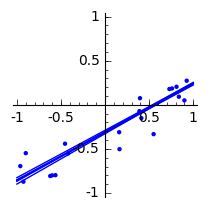

In [8]:
# グラフ表示用の変数
x, y = var('x, y')
# 20個目の事後平均と分散を計算
v = vector(xv)
t = vector(tv)
Phi = matrix([[ _phi(x,j) for j in range(2)] for x in v.list()])
Phi_t = Phi.transpose()
S_N_inv = (alpha*matrix((2),(2),1) + beta*Phi_t * Phi)
S_N = S_N_inv.inverse()
m_N = beta*S_N*Phi_t*t
# 20個目の事後分布
cnt_plt = contour_plot(lambda x, y : gauss_v(vector([x,y]), m_N, S_N), [x, -1, 1], [y, -1, 1], fill=False)
(cnt_plt + a_plt).show(aspect_ratio=1, figsize=3)
# 6個のラインを引く
L = matrix(cholesky(S_N.numpy()))
y = m_N + L*vector([random(), random()])
l_plt = data_plt
for i in range(6):
    y = m_N + L*vector([random(), random()])
    l_plt += plot(lambda x : y[0] + y[1]*x, [x, -1, 1])
l_plt.show(aspect_ratio=1, figsize=3, xmin=-1, xmax=1, ymin=-1, ymax=1)